## Title: Urbanization and Biodiversity Loss: Analyzing the Impact on Phoenix, AZ (2017-2020)
###### Author: Joshua Mull
###### Github: https://github.com/llumj/Biodiversity_Intactness_Index_change_in_Maricopa_County

#### About

#### Purpose
This notebook examines the impact of urbanization on biodiversity loss in Phoenix, AZ, from 2017 to 2020. Through data analysis and visualization, it aims to identify areas where biodiversity intactness has been most significantly affected.

#### Highlights
- Temporal Analysis: Comparison of biodiversity intactness index (BII) data between 2017 and 2020.

- Spatial Visualization: Identification and visualization of areas with significant biodiversity loss.

- Impact of Urbanization: Correlation between urban expansion and biodiversity loss.

#### About the Data
The data used in this analysis includes the io-biodiversity collection from the Microsoft Planetary Computer STAC catalog as well as a shapefile for Phoenix Subdivision from the Census.gov website. The Biodiversity Intactness Index (BII) is a measure of how much of a region's natural biodiversity remains intact despite human pressures. It estimates the average abundance of native species in a given area compared to their abundance in undisturbed conditions. The BII is calculated using data on plants, fungi, and animals from ecological studies conducted worldwide

#### Load Libraries

In [200]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr
import contextily as ryan 
import pandas as pd 
import matplotlib.lines as mlines




from pystac_client import Client  # To access STAC catalogs

import planetary_computer  # To sign items from the MPC STAC catalog 

from IPython.display import Image  # To nicely display images

#### Import Shapefile 

<Axes: >

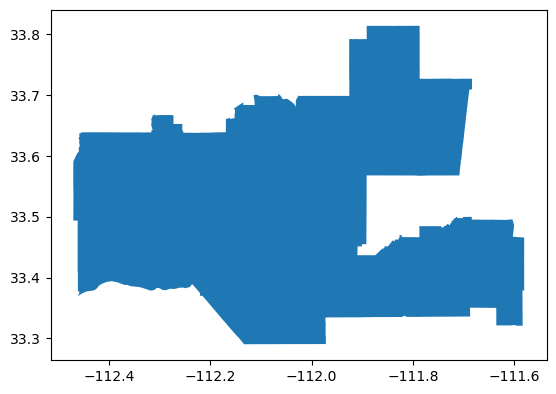

In [64]:
# Import with geopandas 
arizona = gpd.read_file("data/tl_2022_04_cousub.shp")

# Subset to just Phoenix subdivision 
arizona = arizona[arizona.NAME == 'Phoenix']

# Plot to check 
arizona.plot()

#### Access
We use the Client function from the pystac_client package to access the catalog:

In [65]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

#### Catalog Exploration
Let’s check out some of the catalog’s metadata:

In [66]:
# Explore catalog metadata
print('Title:', catalog.title)
print('Description:', catalog.description)

Title: Microsoft Planetary Computer STAC API
Description: Searchable spatiotemporal metadata describing Earth science datasets hosted by the Microsoft Planetary Computer


#### Get Collection

##### List which collections are available

In [67]:
# Get collections and print their names
collections = list(catalog.get_collections())  # Turn generator into list

print('Number of collections:', len(collections))

print("Collections IDs (first 10):")
for i in range(10):
    print('-', collections[i].id)

Number of collections: 124
Collections IDs (first 10):
- daymet-annual-pr
- daymet-daily-hi
- 3dep-seamless
- 3dep-lidar-dsm
- fia
- sentinel-1-rtc
- gridmet
- daymet-annual-na
- daymet-monthly-na
- daymet-annual-hi


In [68]:
io_collection = catalog.get_child('io-biodiversity')
io_collection

<CollectionClient id=io-biodiversity>

#### Collection search 

In [69]:
# Temporal range of interest
time_range = "2017-01-01/2020-01-01"

# NCEAS bounding box (as a GeoJSON)
bbox = { 
    "type": "Polygon", 
        "coordinates": [
     [
        [-112.826843, 32.974108], 
        [-112.826843, 33.863574],
        [-111.184387, 33.863574], 
        [-111.184387, 32.974108], 
        [-112.826843, 32.974108] 
    ] 
],
}

# Catalog search
search = catalog.search(
    collections = ['io-biodiversity'],
    intersects = bbox,
    datetime = time_range)
search

#### Look at the items found in the search 

In [70]:
# Retrieve search items
items = search.item_collection()
len(items)

4

In [71]:
# Print the first index to see what year 
print(items[0].properties)

{'datetime': None, 'proj:epsg': 4326, 'proj:shape': [7992, 7992], 'end_datetime': '2020-12-31T23:59:59Z', 'proj:transform': [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215, 34.74464974521749, 0.0, 0.0, 1.0], 'start_datetime': '2020-01-01T00:00:00Z'}


#### Retrieve years 2017 and 2020 in the collection

In [72]:
# index 3 for year 2017
year_2017 = items[3]
type(year_2017)

# index 0 for 2020
year_2020 = items[0]
type(year_2020)

pystac.item.Item

#### See what assests are available

In [73]:
# Print assests for each one 
for key in year_2017.assets.keys():
    print(key, '--', year_2017.assets[key].title)
    
for key in year_2020.assets.keys():
    print(key, '--', year_2020.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview
data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


#### Plot a quick preview 

In [74]:
# Plot rendered preview
Image(url=year_2017.assets['rendered_preview'].href, width=500)

In [75]:
#### Pull in data for Biodiversity Intactness Index for both years 
BII_2017 = rioxr.open_rasterio(year_2017.assets['data'].href)
BII_2017

BII_2020 = rioxr.open_rasterio(year_2020.assets['data'].href)
BII_2020

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

#### Drop the bands to make plotting easier later

In [76]:
# Original dimensions and coordinates
print(BII_2017.dims, BII_2017.coords,'\n')
print(BII_2020.dims, BII_2020.coords,'\n')

# Remove length 1 dimension (band)
BII_2017 = BII_2017.squeeze()
BII_2020 = BII_2020.squeeze()
print(BII_2017.dims, BII_2017.coords,'\n')
print(BII_2020.dims, BII_2020.coords,'\n')

# Remove coordinates associated to band
BII_2017 = BII_2017.drop_vars('band')
BII_2020 = BII_2020.drop_vars('band')
print(BII_2017.dims, BII_2017.coords)
print(BII_2020.dims, BII_2020.coords)

('band', 'y', 'x') Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0 

('band', 'y', 'x') Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0 

('y', 'x') Coordinates:
    band         int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0 

('y', 'x') Coordinates:
    band         int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0 

('

#### Plot Phoneix Subdivision on basemap

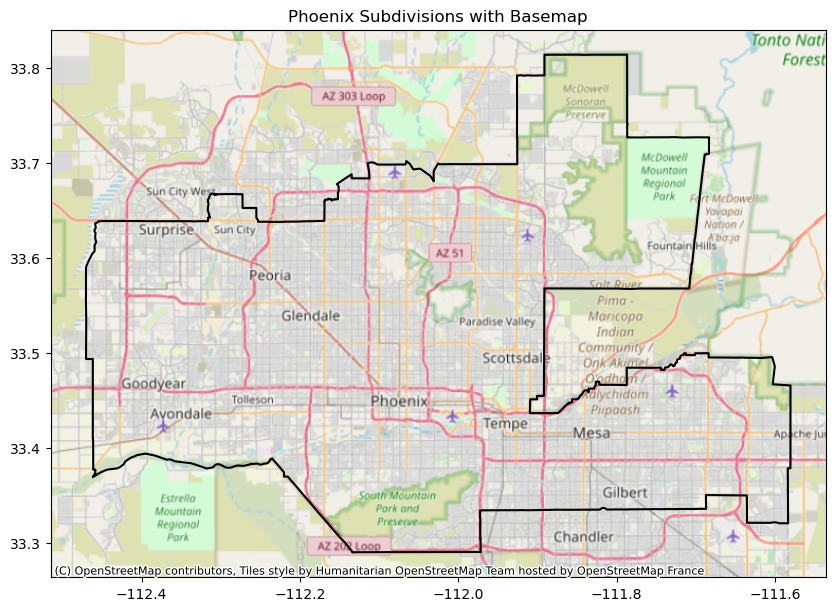

In [77]:
# Plot the shapefile
fig, ax = plt.subplots(figsize=(10, 10))
arizona.boundary.plot(ax=ax, alpha=1, edgecolor='k')

# Add the basemap
ryan.add_basemap(ax, crs=arizona.crs)

plt.title('Phoenix Subdivisions with Basemap')
plt.show()


#### Change in BII

##### Clip raster to Phoneix subdivision 

In [113]:
# Clip bounding box
BII_2017_clip = (BII_2017.rio.clip_box(*arizona.total_bounds)
                 .rio.clip(arizona.geometry))
BII_2020_clip = (BII_2020.rio.clip_box(*arizona.total_bounds)
                .rio.clip(arizona.geometry))

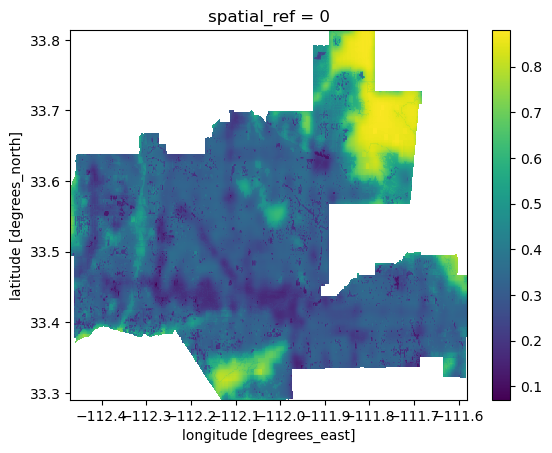

In [79]:
# Plot to check 
BII_2017_clip.plot()

#### Find area where BII is greater than .75

In [138]:
BII_2017_75 = BII_2017_clip >= 0.75
BII_2020_75 = BII_2020_clip >= 0.75

BII_2017_75 = BII_2017_75.fillna(0)
BII_2020_75 = BII_2020_75.fillna(0)

BII_diff = BII_2017_75.astype('int') - BII_2020_75.astype('int')

BII_diff = BII_diff.where(BII_diff == 1)

Text(0.5, 1.0, 'Biodiversity Intactness Index (BII)\nPhoenix Subdivision')

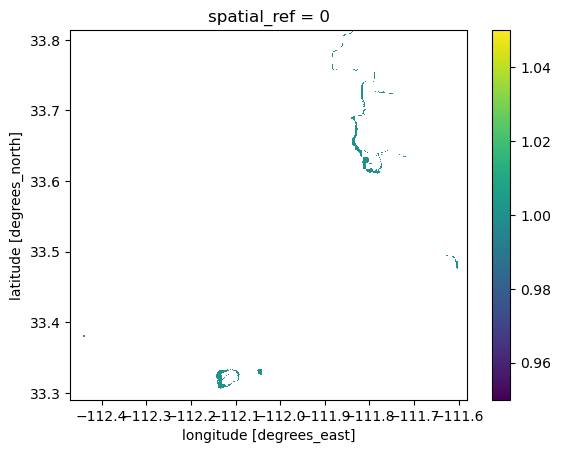

In [212]:
BII_diff.plot()

#### Calculate percent

##### Use function to calculate the total area BII >= .75 for each year

In [84]:
# Define a function to calculate the percentage of area with BII >= 0.75
def calculate_percentage_area(raster_data, threshold=0.75):
    # Get the total number of pixels
    total_pixels = raster_data.data[0].size
    
    # Identify pixels with BII >= threshold
    high_bii_pixels = np.count_nonzero(raster_data.data[0] >= threshold)
    
    # Calculate the percentage
    percentage = (high_bii_pixels / total_pixels) * 100
    return percentage

# Calculate the percentage for 2017 and 2020
percentage_2017 = calculate_percentage_area(BII_2017_clip)
percentage_2020 = calculate_percentage_area(BII_2020_clip)

print(f"Percentage of Phoenix subdivision area with BII >= 0.75 in 2017: {percentage_2017:.2f}%")
print(f"Percentage of Phoenix subdivision area with BII >= 0.75 in 2020: {percentage_2020:.2f}%")


Percentage of Phoenix subdivision area with BII >= 0.75 in 2017: 5.56%
Percentage of Phoenix subdivision area with BII >= 0.75 in 2020: 5.35%


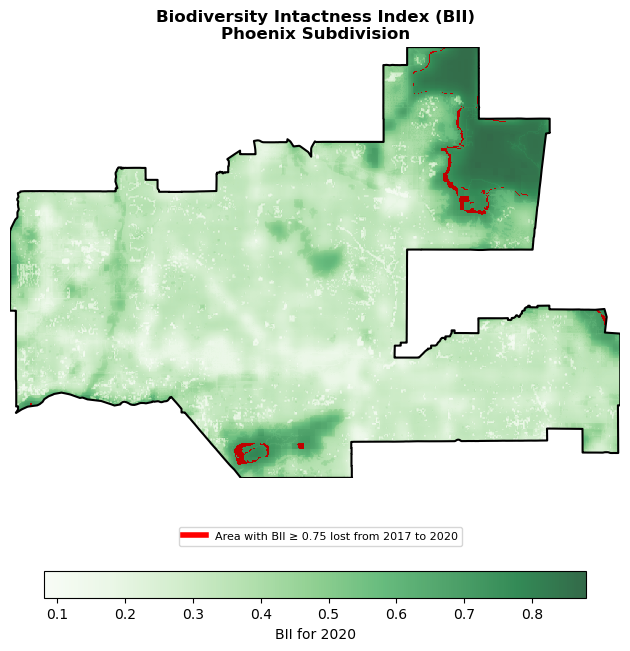

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8)) # Establish figure 


BII_2020_clip.plot(ax=ax, 
             cmap='Greens', 
             alpha=0.8,
             cbar_kwargs={'orientation': 'horizontal', # Plot BII 2020 raster
                         'label': 'BII for 2020',
                         'shrink': .7})

arizona.boundary.plot(ax=ax, 
                      color = 'black') # Plot Phoenix Subdivision boundary

BII_diff.plot(ax=ax, 
          cmap = 'gist_heat', 
          linewidths=0.5, add_colorbar = False) # Plot difference in BII raster

red_patch = mlines.Line2D([], [], 
                          color='red', 
                          label='Area with BII ≥ 0.75 lost from 2017 to 2020',  # Add red patch for legend
                          linewidth=4)

ax.legend(handles=[red_patch], 
          bbox_to_anchor = (0, -.1, 0.75, 0), # Add legend
          fontsize=8)

ax.set_title('Biodiversity Intactness Index (BII)\nPhoenix Subdivision', fontweight = 'bold') # Add title
ax.axis('off')
plt.show()

#### Results

The plot depicts the 2020 BII percentage for Phoenix Subdivision in green. The higher the percentage, the more biodiversity. The red area shows the BII area with a >= .75 (i.e 75%) that has been lost from 2017. 
